# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap
6. The differential gene cluster identification

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scMVP.dataset import SciCarDemo
from scMVP.models import VAE
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch
from scMVP.models.multi_vae import Multi_VAE

## Visualizing the latent space with scanpy
import scanpy as sc
import anndata

## Loading data

 Loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 

Data url: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE117089&format=file

In [3]:
test_mode = False
n_epochs_all = None
show_plot = True

save_path = "dataset/sci_car/"

dataset = SciCarDemo(dataset_name="CellLineMixture",data_path=save_path)

[2020-09-24 14:10:56,670] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2020-09-24 14:11:12,072] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2020-09-24 14:11:13,963] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-24 14:11:13,965] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2020-09-24 14:11:16,187] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 14:11:17,242] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells


## Manual data filtering 

In [4]:
def filter_dataset(dataset):
    # filter genes expressed in more than 1% of cells
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)
    
    # Manual filter cells detect over certain gene counts
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 50
    #high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 10)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_atac_cells)
    dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)


[2020-09-24 14:12:06,185] INFO - scMVP.dataset.dataset | Downsampling from 113153 to 20403 genes
[2020-09-24 14:12:06,844] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 14:12:07,189] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2020-09-24 14:12:08,566] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 14:12:08,711] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2020-09-24 14:12:10,665] INFO - scMVP.dataset.dataset | Downsampling from 20403 to 10000 genes
[2020-09-24 14:12:11,115] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 14:12:11,283] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2020-09-24 14:12:12,420] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 14:12:12,493] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2020-09-24 14:12:14,369] INFO - scMVP.

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [5]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True
n_centroids = 5
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

<All keys matched successfully>

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
    (var_encoder): Linear(in_features=1

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


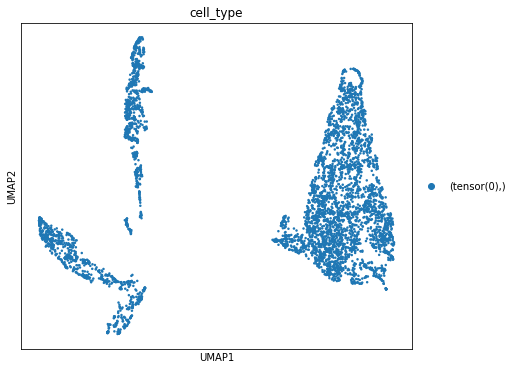

In [6]:
train_model_path = "dataset/pretrain_model/"

pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5
)
is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/scMVP_tutorial_GMM.pkl' % train_model_path)

if os.path.isfile('%s/scMVP_tutorial_GMM.pkl' % train_model_path):
    pre_trainer.model.load_state_dict(torch.load('%s/scMVP_tutorial_GMM.pkl' % train_model_path))
    pre_trainer.model.eval()
else:
    #pre_trainer.model.init_gmm_params(dataset)
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/scMVP_tutorial_GMM.pkl' % train_model_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
for tensors_list in range(int(len(imputed_values)/256)+1):
    if tensors_list == range(int(len(imputed_values)/256)):
        x = torch.zeros((256,len(imputed_values[0])))
        x[0:len(x)-256*tensors_list,:] = torch.tensor(imputed_values[tensors_list * 256:len(imputed_values), :])
        y = torch.zeros((256))
        y[0:len(x)-256*tensors_list,:]  = torch.tensor(dataset.labels[tensors_list * 256:len(imputed_values)].astype(int))
        temp_samples = pre_trainer.model.get_latents(x,y)
        for temp_sample in temp_samples:
            sample_latents = torch.cat((sample_latents, temp_sample[0:len(x)-256*tensors_list,:].float()))
    temp_samples = pre_trainer.model.get_latents(
        x=torch.tensor(imputed_values[tensors_list * 256:(1 + tensors_list) * 256, :]),
        y=torch.tensor(dataset.labels[tensors_list * 256:(1 + tensors_list) * 256].astype(int)))
    for temp_sample in temp_samples:
        sample_latents = torch.cat((sample_latents, temp_sample.float()))
        
# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
prior_adata.obs['cell_type'] = torch.tensor(dataset.labels[0:len(sample_latents)].astype(int))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in the your given path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [7]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(sample_latents.detach().numpy())

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_tutorial_mmvae.pkl' % train_model_path)
if os.path.isfile('%s/scMVP_tutorial_mmvae.pkl' % train_model_path):
    trainer.model.load_state_dict(torch.load('%s/scMVP_tutorial_mmvae.pkl' % train_model_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_tutorial_mmvae.pkl' % train_model_path)

<All keys matched successfully>

Multi_VAE(
  (RNA_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (ATAC_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=87240, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(i

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

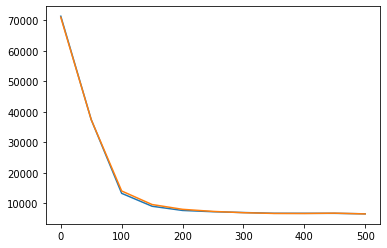

In [17]:
## If you train your own model, you can plot the elbo value during training.
## If your load pre-trained model, the plot would be empty.

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)


Query the imputed values via the `imputation` method of the posterior object and get common latent embedding. 

In [8]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))

## Cell clustering
Perform cell clustering and merging the rare clusters which less than 10 cells

In [9]:
clust_index_gmm = trainer.model.init_gmm_params(sample_latents.detach().numpy())
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

Visualizing common latent embedding and cell clustering by scMVP

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


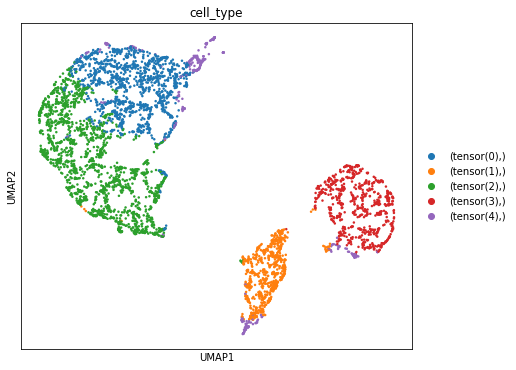

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


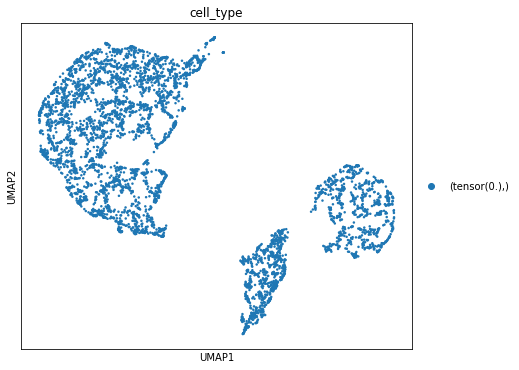

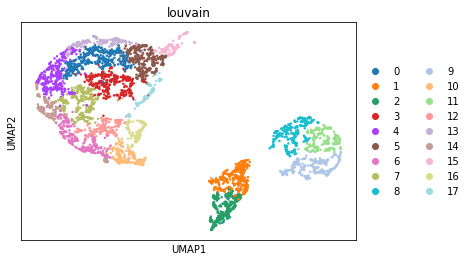

In [10]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
posterior_adata.obs['cell_type'] = torch.tensor(clust_index_gmm.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels
posterior_adata.obs['cell_type'] = torch.tensor(sample_labels.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
#matplotlib.use('TkAgg')
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
sc.tl.louvain(posterior_adata)
sc.pl.umap(posterior_adata, color=['louvain'])

## differential gene and peak analysis
Identification differential genes and peaks in each cell cluster

... storing 'louvain' as categorical
/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/scanpy-1.6.0-py3.7.egg/scanpy/tools/_rank_genes_groups.py:405: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/scanpy-1.6.0-py3.7.egg/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: divide by zero encountered in log2
  foldchanges[global_indices]
/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/scanpy-1.6.0-py3.7.egg/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


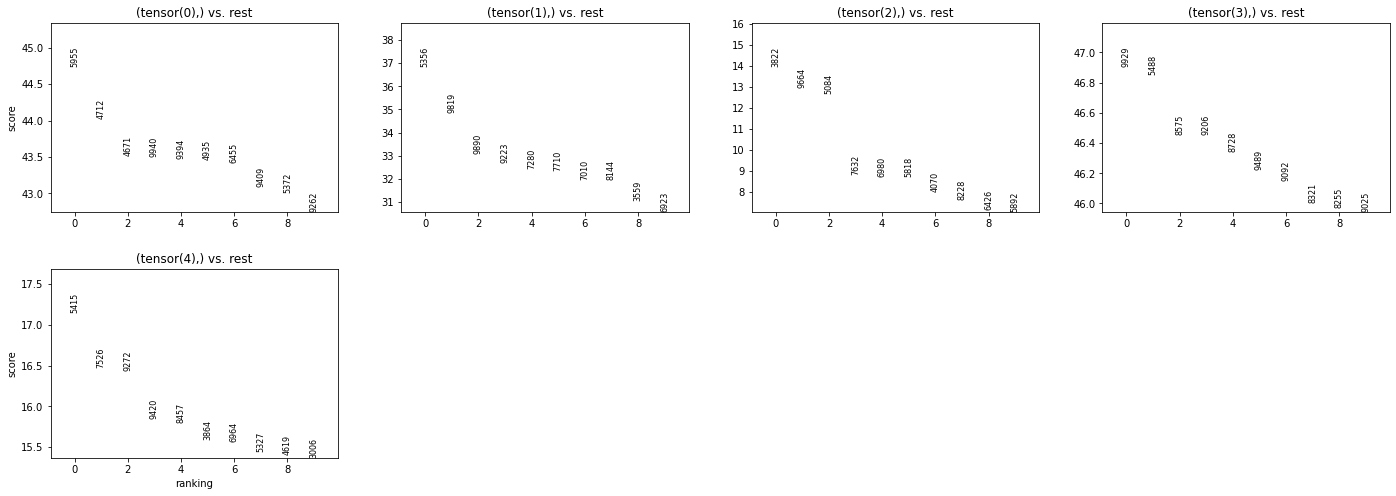

In [11]:
posterior_adata.obs['louvain'] = torch.tensor(gmm_clus_index.reshape(-1,1))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])

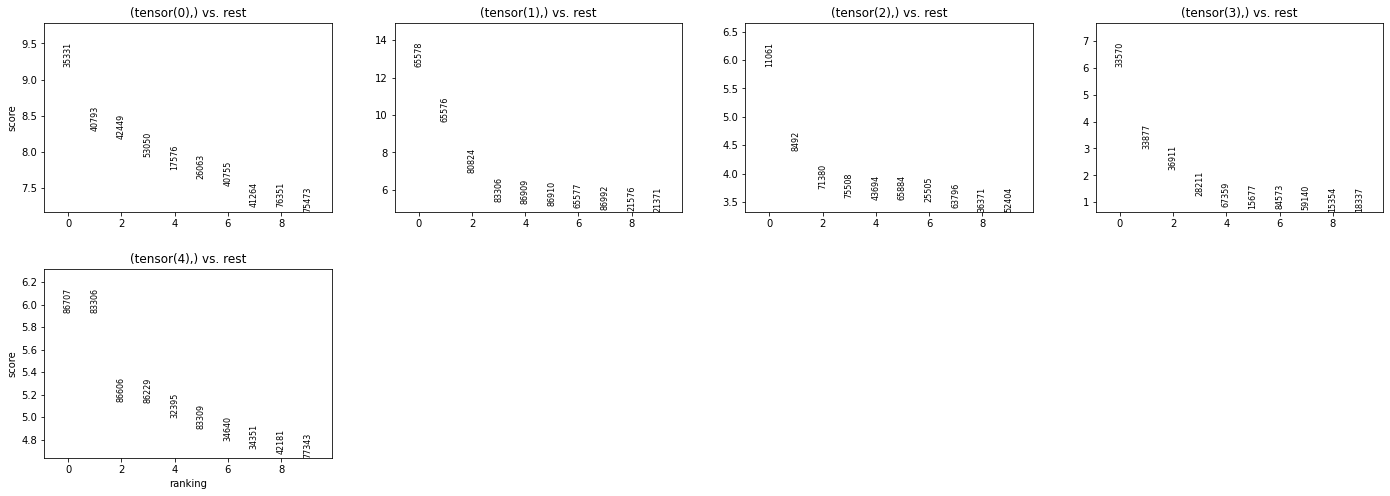

In [12]:
atac_posterior_adata = anndata.AnnData(X=atac_imputation)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])